In [64]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

In [2]:
splits, info = tfds.load("horses_or_humans",
                         as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'],
                         data_dir="./data")

train_examples, validation_examples, test_examples = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
num_examples, num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling data/horses_or_humans/3.0.0.incompleteRDYFO2/horses_or_humans-train.tfrecord*...:   0%|          | 0…

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling data/horses_or_humans/3.0.0.incompleteRDYFO2/horses_or_humans-test.tfrecord*...:   0%|          | 0/…

Dataset horses_or_humans downloaded and prepared to ./data/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


(1027, 2)

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [4]:
# Create a autograph pre-processing function to resize and normalize an image
### START CODE HERE ###
@tf.function
def map_fn(image, label):
  img = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  img /= 255.
  return img, label

In [5]:
## TEST CODE:

test_image, test_label = list(train_examples)[0]

test_result = map_fn(test_image, test_label)

print(test_result[0].shape)
print(test_result[1].shape)

del test_image, test_label, test_result

(224, 224, 3)
()


In [6]:
train_ds = train_examples.map(map_fn).shuffle(buffer_size=1024).batch(BATCH_SIZE)
valid_ds = validation_examples.map(map_fn).batch(BATCH_SIZE)
test_ds = test_examples.map(map_fn).batch(BATCH_SIZE)

In [8]:
## TEST CODE:

test_train_ds = list(train_ds)
print(len(test_train_ds))
print(test_train_ds[0][0].shape)

del test_train_ds

26
(32, 224, 224, 3)


In [47]:
MODULE_HANDLE = "https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1"
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

In [50]:
def set_adam_optimizer():
  optimizer = tf.keras.optimizers.Adam()
  return optimizer

In [51]:
## TEST CODE:

test_optimizer = set_adam_optimizer()

print(type(test_optimizer))

del test_optimizer

<class 'keras.src.optimizers.adam.Adam'>


In [52]:
def set_sparse_cat_crossentropy_loss():
  train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
  val_loss = tf.keras.losses.SparseCategoricalCrossentropy()
  return train_loss, val_loss

In [53]:
## TEST CODE:

test_train_loss, test_val_loss = set_sparse_cat_crossentropy_loss()

print(type(test_train_loss))
print(type(test_val_loss))

del test_train_loss, test_val_loss

<class 'keras.src.losses.SparseCategoricalCrossentropy'>
<class 'keras.src.losses.SparseCategoricalCrossentropy'>


In [54]:
def set_sparse_cat_crossentropy_accuracy():
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
  val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
  return train_accuracy, val_accuracy

In [55]:
## TEST CODE:

test_train_accuracy, test_val_accuracy = set_sparse_cat_crossentropy_accuracy()

print(type(test_train_accuracy))
print(type(test_val_accuracy))

del test_train_accuracy, test_val_accuracy

<class 'keras.src.metrics.accuracy_metrics.SparseCategoricalAccuracy'>
<class 'keras.src.metrics.accuracy_metrics.SparseCategoricalAccuracy'>


In [56]:
optimizer = set_adam_optimizer()
train_loss, val_loss = set_sparse_cat_crossentropy_loss()
train_accuracy, val_accuracy = set_sparse_cat_crossentropy_accuracy()

In [57]:
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
EPOCHS = 2
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
  with tf.GradientTape() as tape:
    y_pred = model(x)
    loss = train_loss(y, y_pred)

  gradients = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  train_accuracy(y, y_pred)
  return loss

In [58]:
## TEST CODE:

def base_model():
    inputs = tf.keras.layers.Input(shape=(2))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

test_model = base_model()

test_optimizer = set_adam_optimizer()
test_image = tf.ones((2,2))
test_label = tf.ones((1,))
test_train_loss, _ = set_sparse_cat_crossentropy_loss()
test_train_accuracy, _ = set_sparse_cat_crossentropy_accuracy()

test_result = train_one_step(test_model, test_optimizer, test_image, test_label, test_train_loss, test_train_accuracy)
print(test_result)

del test_result, test_model, test_optimizer, test_image, test_label, test_train_loss, test_train_accuracy

tf.Tensor(0.6931472, shape=(), dtype=float32)


In [59]:
@tf.function
def train(model, optimizer, epochs, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):

  step = 0
  loss = 0.0
  for epoch in range(epochs):
    for x_batch_train, y_batch_train in train_ds:
      step += 1
      loss = train_one_step(model, optimizer, x_batch_train, y_batch_train, train_loss, train_accuracy)
      acc_train = train_accuracy.result()
      tf.print('Step', step,
                   ': train loss', loss,
                   '; train accuracy', train_accuracy.result())


    for x_batch_val, y_batch_val in valid_ds:
      y_pred = model(x_batch_val)
      loss = val_loss(y_batch_val, y_pred)
      val_accuracy(y_batch_val, y_pred)

    tf.print('val loss', loss, '; val accuracy', val_accuracy.result())






In [60]:
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy)

Step 1 : train loss 1.44232702 ; train accuracy 0.375
Step 2 : train loss 1.19569516 ; train accuracy 0.359375
Step 3 : train loss 1.21116948 ; train accuracy 0.34375
Step 4 : train loss 0.979507685 ; train accuracy 0.3828125
Step 5 : train loss 0.610723436 ; train accuracy 0.4375
Step 6 : train loss 0.430329561 ; train accuracy 0.505208313
Step 7 : train loss 0.362267852 ; train accuracy 0.558035731
Step 8 : train loss 0.258081794 ; train accuracy 0.61328125
Step 9 : train loss 0.207342595 ; train accuracy 0.65625
Step 10 : train loss 0.116566971 ; train accuracy 0.690625
Step 11 : train loss 0.12191359 ; train accuracy 0.71875
Step 12 : train loss 0.103144541 ; train accuracy 0.7421875
Step 13 : train loss 0.0548860617 ; train accuracy 0.762019217
Step 14 : train loss 0.0708264932 ; train accuracy 0.779017866
Step 15 : train loss 0.04629042 ; train accuracy 0.79375
Step 16 : train loss 0.0360249132 ; train accuracy 0.806640625
Step 17 : train loss 0.0279179681 ; train accuracy 0.8180

In [61]:
test_imgs = []
test_labels = []

predictions = []
with tf.device(device_name=device):
    for images, labels in test_ds:
        preds = model(images)
        preds = preds.numpy()
        predictions.extend(preds)

        test_imgs.extend(images.numpy())
        test_labels.extend(labels.numpy())

In [62]:
# Utilities for plotting

class_names = ['horse', 'human']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    # green-colored annotations will mark correct predictions. red otherwise.
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    # print the true label first
    print(true_label)

    # show the image and overlay the prediction
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)



1


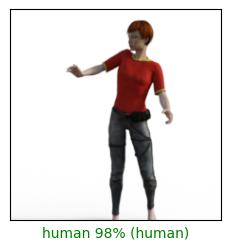

In [80]:
# Visualize the outputs

# you can modify the index value here from 0 to 255 to test different images
index = 250
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()